# Animal Image Classification (DOG, CAT and PANDA)   
[Data Information]   
Data Source: https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda   
Data Folder Name : 'animals'   

[Image]   
cats: "cats_0001.jpg ~ cats_1000.jpg" (1,000)   
dogs: "dogs_0001.jpg ~ dogs_1000.jpg" (1,000)   
panda: "panda_0001.jpg ~ panda_1000.jpg" (1,000)   

[Version]   
High Augmented, 64x64, CNN Model3

## 0. Setting

### Goole Drive Connecting

In [1]:
pwd

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/Code Lion'

/content/drive/MyDrive/Code Lion


In [4]:
!ls

 Animal_Image_128.csv				 'CNN Lecture'
 Animal_Image_32.csv				  data
 Animal_Image_64_clean.csv			  figure
 Animal_Image_64.csv				  JunHyeok_Main.ipynb
'Animal Image Classification.ipynb'		  Mecab-ko-for-Google-Colab
'Animal Image Classification_Model1_0.73.ipynb'   model_save
'Animal Image Classification_Model1_0.76.ipynb'  'Text Mining Lecture'
'Animal Image Classification_Model1_0.84.ipynb'   Training_checkpoint
'Animal Image Classification_ResNet_0.65.ipynb'


### Library Call

In [5]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
from skimage.transform import resize   # 이미지 크기 조정
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Activation, Flatten, Dense
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [13]:
# Constant Definition
class_label = {0:'cat', 1:'dog', 2:'panda'}
imgR = 64
imgC = 64
channel = 3
raw_image_num = 3000

# Image Contrast & Correction
def img_contrast(img):
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l,a,b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize=(8,8))
  cl = clahe.apply(l)
  limg = cv2.merge((cl,a,b))
  temp = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
  final = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
  return final

# Image Load
def load_img(flist): # path내의 모든 jpg 파일 불러오기
    img_list = []
    for file in flist:
        img = cv2.imread(file)
        img = img_contrast(img)
        img = resize(img, (imgR, imgC, channel))
        img_list.append(img)
    return np.array(img_list)

# plot_Images
def plot_Images(nRow, nCol, df):
  df = df.reset_index(drop=True)
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1 : axis = ax[j]
      else:          axis = ax[i,j]
      axis.set_title(f'label = {df.iloc[i*nCol+j,-1]}')
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(df.iloc[i*nCol+j,:-1].values.reshape(imgR,imgC,channel))
      plt.axis('off')
  plt.show()

# Get Clf Evaluation Metrics
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred,average='macro')
    rec = recall_score(y_test,pred,average='macro')
    f1 = f1_score(y_test,pred,average='macro')
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
    # return [acc, pre, rec, f1]        

## 1. Data Load

In [8]:
# glob Function jpg file Loading
cat_filst = sorted(glob('data/cats/*.jpg'))
dog_filst = sorted(glob('data/dogs/*.jpg'))
panda_filst = sorted(glob('data/panda/*.jpg'))

print('cat_filst :',len(cat_filst))
print('dog_filst :',len(dog_filst))
print('panda_filst :',len(panda_filst))

cat_filst : 1000
dog_filst : 1000
panda_filst : 1000


In [9]:
cat_filst[:4]

['data/cats/cats_00001.jpg',
 'data/cats/cats_00002.jpg',
 'data/cats/cats_00003.jpg',
 'data/cats/cats_00004.jpg']

In [14]:
# Image Loading
cat_image = load_img(cat_filst)
dog_image = load_img(dog_filst)
panda_image = load_img(panda_filst)

print('cat_image :',cat_image.shape)
print('dog_image :',dog_image.shape)
print('panda_image :',panda_image.shape)

cat_image : (1000, 64, 64, 3)
dog_image : (1000, 64, 64, 3)
panda_image : (1000, 64, 64, 3)


In [15]:
# Image Concatenate
image = np.concatenate([cat_image,dog_image])
image = np.concatenate([image,panda_image])

In [16]:
# Image DataFrame Definition
df = pd.DataFrame(image.reshape(raw_image_num,-1), columns = np.arange(imgR*imgC*channel))
df['label'] = np.array([[0]*len(cat_image),[1]*len(dog_image),[2]*len(panda_image)]).reshape(-1)
print('df.shape :',df.shape)
df.head(2)

df.shape : (3000, 12289)


,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,0.275490,0.485909,0.604902,0.317892,0.543689,0.655643,0.338909,0.572601,0.684007,0.344485,...,0.238848,0.166483,0.084252,0.220521,0.174872,0.093811,0.333335,0.274512,0.218997,0
1,0.244054,0.285503,0.358885,0.339859,0.365341,0.459130,0.458745,0.448652,0.528799,0.510355,...,0.062776,0.076182,0.078383,0.214951,0.180423,0.145895,0.438016,0.421780,0.411029,0


In [17]:
df.to_csv('Animal_Image_64_corr.csv', index=False)

In [18]:
df = pd.read_csv('Animal_Image_64_corr.csv')
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,0.275490,0.485909,0.604902,0.317892,0.543689,0.655643,0.338909,0.572601,0.684007,0.344485,...,0.238848,0.166483,0.084252,0.220521,0.174872,0.093811,0.333335,0.274512,0.218997,0
1,0.244054,0.285503,0.358885,0.339859,0.365341,0.459130,0.458745,0.448652,0.528799,0.510355,...,0.062776,0.076182,0.078383,0.214951,0.180423,0.145895,0.438016,0.421780,0.411029,0


In [19]:
df['label'].value_counts()

0    1000
1    1000
2    1000
Name: label, dtype: int64

## 2. Data EDA & Preprocessing

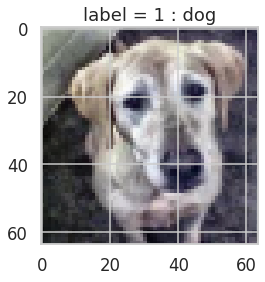

In [20]:
# Random Image Sample Visualization
rnd_idx = np.random.randint(3000,size=1)
plt.imshow(df.iloc[rnd_idx,:-1].values.reshape(imgR,imgC,channel))
plt.title(f'label = {df.iloc[rnd_idx,-1].values[0]} : {class_label[df.iloc[rnd_idx,-1].values[0]]}')
plt.show()

<Figure size 432x288 with 0 Axes>

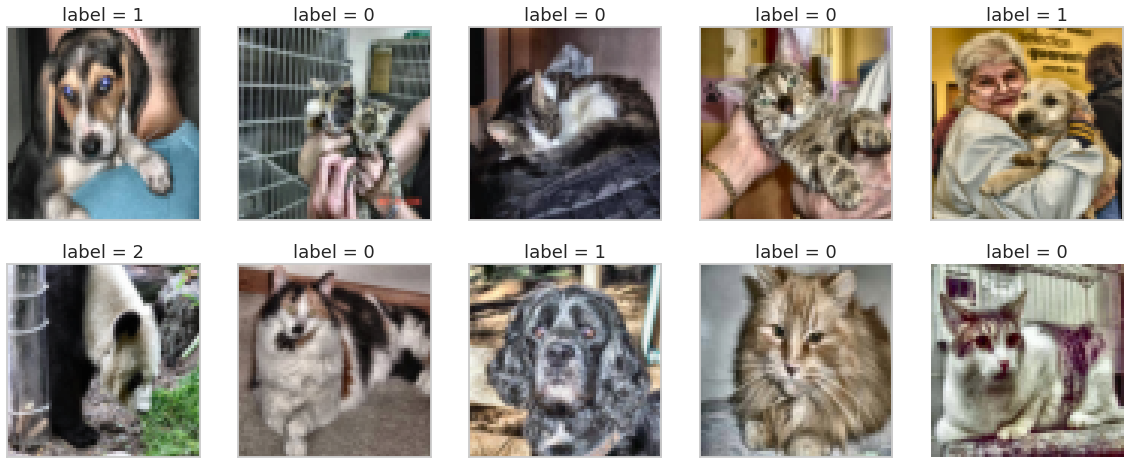

In [21]:
# Random Image Samples Visualization
random_idx = np.random.randint(df.shape[0],size=10)
plot_Images(2,5,df.iloc[random_idx])

In [22]:
# Data and Target Split
X = df.drop('label',axis=1)
y = df['label']

# train_valid_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, random_state=31, test_size=0.2, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=31, test_size=0.2, shuffle=True)

# Image Data Transformation
X_train = X_train.to_numpy().reshape(-1,imgR,imgC,channel)
X_valid = X_valid.to_numpy().reshape(-1,imgR,imgC,channel)
X_test = X_test.to_numpy().reshape(-1,imgR,imgC,channel)

print('X_train :',X_train.shape)
print('X_valid :',X_valid.shape)
print('X_test :',X_test.shape)
print('y_train :',y_train.shape)
print('y_valid :',y_valid.shape)
print('y_test :',y_test.shape)

X_train : (1920, 64, 64, 3)
X_valid : (480, 64, 64, 3)
X_test : (600, 64, 64, 3)
y_train : (1920,)
y_valid : (480,)
y_test : (600,)


In [23]:
# Image Augmentation
image_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 90,
    brightness_range = [0.8,1.2],
    shear_range = 0.3,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode = 'nearest'
)

augment_size = X_train.shape[0]

it = image_generator.flow(X_train, y_train, batch_size=augment_size, seed=42)

X_aug, y_aug = it.next()
for i in range(12):
  X_new, y_new = it.next()
  X_aug = np.concatenate((X_aug,X_new))
  y_aug = np.concatenate((y_aug,y_new))

print('X_aug.shape :',X_aug.shape)
print('y_aug.shape :',y_aug.shape)

X_aug.shape : (24960, 64, 64, 3)
y_aug.shape : (24960,)


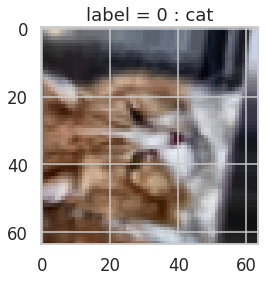

In [24]:
# Augmentation Image Sample Visualization
rnd_idx = np.random.randint(X_aug.shape[0],size=1)
plt.imshow(X_aug[rnd_idx][0])
plt.title(f'label = {y_aug[rnd_idx][0]} : {class_label[y_aug[rnd_idx][0]]}')
plt.show()

In [25]:
np.unique(y_aug, return_counts=True)

(array([0, 1, 2]), array([8320, 8320, 8320]))

In [26]:
# Train Data Integration
X_train = np.concatenate((X_train,X_aug))
y_train = np.concatenate((y_train,y_aug))

print('X_train.shape :',X_train.shape)
print('y_train.shape :',y_train.shape)

X_train.shape : (26880, 64, 64, 3)
y_train.shape : (26880,)


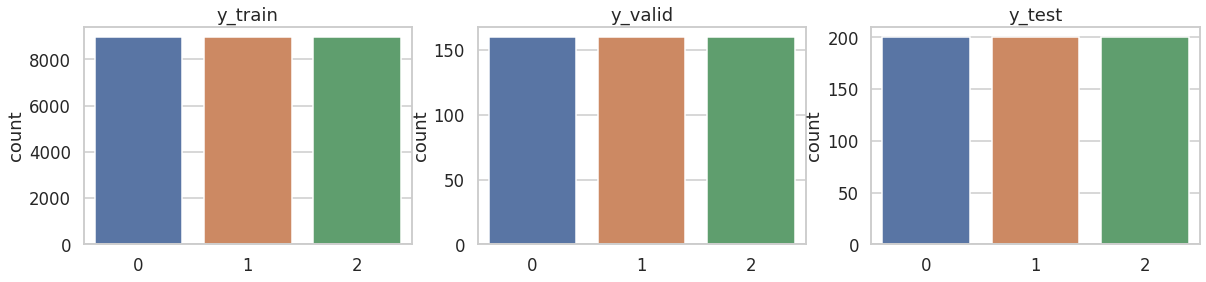

In [27]:
# Target value Distribution
fig, ax = plt.subplots(1,3,figsize=(20,4))

sns.countplot(y_train, ax=ax[0])
sns.countplot(y_valid.values, ax=ax[1])
sns.countplot(y_test.values, ax=ax[2])

ax[0].set_title('y_train')
ax[1].set_title('y_valid')
ax[2].set_title('y_test')
plt.show()

In [28]:
# One-Hot Encoding
y_train = pd.get_dummies(y_train).reset_index(drop=True)
y_valid = pd.get_dummies(y_valid).reset_index(drop=True)
y_test = pd.get_dummies(y_test).reset_index(drop=True)

print('y_train :',y_train.shape)
print('y_valid :',y_valid.shape)
print('y_test :',y_test.shape)

y_train : (26880, 3)
y_valid : (480, 3)
y_test : (600, 3)


## 3. Modeling

### Model 3. CNN 

In [48]:
# CNN 인공신경망 정의
def create_model3():
    model = Sequential()

    model.add(layers.Conv2D(64, (5,5), strides=2, padding='same', activation='relu', input_shape=(imgR,imgC,channel)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, kernel_regularizer='l2', activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(3, activation='softmax'))
    return model

In [49]:
# CNN Model3 Object Create
model3 = create_model3()

# ExponentialDecay Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.9)

# Model Compile
optimizer_use = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
model3.compile(optimizer=optimizer_use, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [50]:
# Model Summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

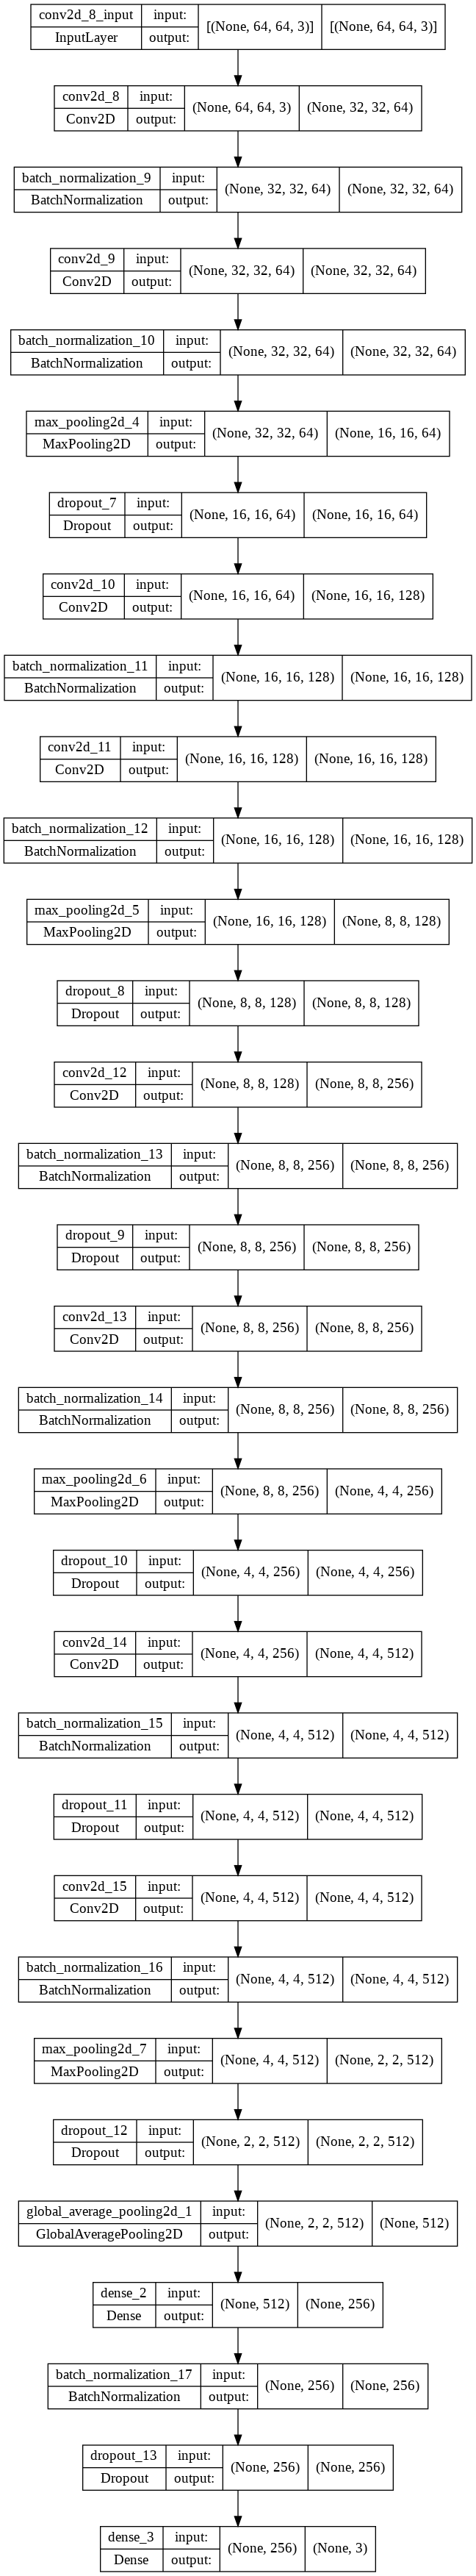

In [51]:
plot_model(model3, to_file='figure/model3_shapes.png', show_shapes=True)

In [52]:
# CallBack Functions
checkpoint_dir = 'Training_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'
patience_time = 15

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=patience_time)
cp = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, verbose=1,
                                       save_weights_only = True,
                                       save_best_only = True)

In [53]:
# Training
tqdm_callback = tfa.callbacks.TQDMProgressBar()

start = time.time()
history = model3.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
                   batch_size=32, verbose=0,
                   callbacks=[early_stopping, cp, tqdm_callback])
end = time.time()
history

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/840           ETA: ?s - 


Epoch 1: val_loss improved from inf to 1.63967, saving model to Training_checkpoint/cp-0001-1.64.ckpt
Epoch 2/100


0/840           ETA: ?s - 


Epoch 2: val_loss improved from 1.63967 to 0.71395, saving model to Training_checkpoint/cp-0002-0.71.ckpt
Epoch 3/100


0/840           ETA: ?s - 


Epoch 3: val_loss did not improve from 0.71395
Epoch 4/100


0/840           ETA: ?s - 


Epoch 4: val_loss improved from 0.71395 to 0.68779, saving model to Training_checkpoint/cp-0004-0.69.ckpt
Epoch 5/100


0/840           ETA: ?s - 


Epoch 5: val_loss did not improve from 0.68779
Epoch 6/100


0/840           ETA: ?s - 


Epoch 6: val_loss did not improve from 0.68779
Epoch 7/100


0/840           ETA: ?s - 


Epoch 7: val_loss improved from 0.68779 to 0.62333, saving model to Training_checkpoint/cp-0007-0.62.ckpt
Epoch 8/100


0/840           ETA: ?s - 


Epoch 8: val_loss did not improve from 0.62333
Epoch 9/100


0/840           ETA: ?s - 


Epoch 9: val_loss did not improve from 0.62333
Epoch 10/100


0/840           ETA: ?s - 


Epoch 10: val_loss did not improve from 0.62333
Epoch 11/100


0/840           ETA: ?s - 


Epoch 11: val_loss did not improve from 0.62333
Epoch 12/100


0/840           ETA: ?s - 


Epoch 12: val_loss improved from 0.62333 to 0.60802, saving model to Training_checkpoint/cp-0012-0.61.ckpt
Epoch 13/100


0/840           ETA: ?s - 


Epoch 13: val_loss did not improve from 0.60802
Epoch 14/100


0/840           ETA: ?s - 


Epoch 14: val_loss improved from 0.60802 to 0.58866, saving model to Training_checkpoint/cp-0014-0.59.ckpt
Epoch 15/100


0/840           ETA: ?s - 


Epoch 15: val_loss did not improve from 0.58866
Epoch 16/100


0/840           ETA: ?s - 


Epoch 16: val_loss did not improve from 0.58866
Epoch 17/100


0/840           ETA: ?s - 


Epoch 17: val_loss did not improve from 0.58866
Epoch 18/100


0/840           ETA: ?s - 


Epoch 18: val_loss did not improve from 0.58866
Epoch 19/100


0/840           ETA: ?s - 


Epoch 19: val_loss did not improve from 0.58866
Epoch 20/100


0/840           ETA: ?s - 


Epoch 20: val_loss did not improve from 0.58866
Epoch 21/100


0/840           ETA: ?s - 


Epoch 21: val_loss did not improve from 0.58866
Epoch 22/100


0/840           ETA: ?s - 


Epoch 22: val_loss did not improve from 0.58866
Epoch 23/100


0/840           ETA: ?s - 


Epoch 23: val_loss did not improve from 0.58866
Epoch 24/100


0/840           ETA: ?s - 


Epoch 24: val_loss did not improve from 0.58866
Epoch 25/100


0/840           ETA: ?s - 


Epoch 25: val_loss did not improve from 0.58866
Epoch 26/100


0/840           ETA: ?s - 


Epoch 26: val_loss did not improve from 0.58866
Epoch 27/100


0/840           ETA: ?s - 


Epoch 27: val_loss did not improve from 0.58866
Epoch 28/100


0/840           ETA: ?s - 


Epoch 28: val_loss did not improve from 0.58866
Epoch 29/100


0/840           ETA: ?s - 


Epoch 29: val_loss did not improve from 0.58866


In [54]:
# Training Time Print
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:07:01


In [55]:
# Training History DataFrame
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,2.489364,0.605952,1.639674,0.443750
1,0.792988,0.684598,0.713953,0.718750
2,0.713276,0.715179,0.833238,0.677083
3,0.680808,0.738839,0.687788,0.745833
4,0.647703,0.765737,0.806800,0.679167


In [56]:
# Best Estimator
df_hist.sort_values(by='val_loss').head(1)

,loss,accuracy,val_loss,val_accuracy
13,0.352034,0.915513,0.588661,0.835417


In [68]:
# Model Save
model3.save('model_save/CNN_model3_0.83/')

INFO:tensorflow:Assets written to: model_save/CNN_model3_0.83/assets


INFO:tensorflow:Assets written to: model_save/CNN_model3_0.83/assets


In [69]:
# Model Load
model3 = keras.models.load_model('model_save/CNN_model3_0.83/')

## 4. Performance Evaluation

### Learning Curve

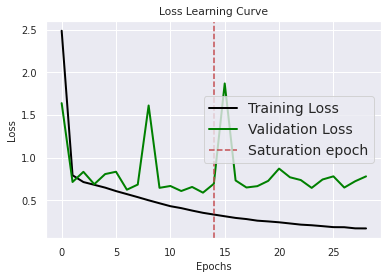

In [57]:
# Loss Learning Curve
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss', color='black', linewidth=2.0)
plt.plot(df_hist.val_loss, label='val_loss', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_time, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
plt.show()

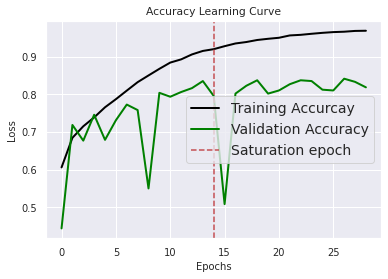

In [66]:
# Accuracy Learning Curve
plt.title('Accuracy Learning Curve')
plt.plot(df_hist.accuracy, label='accuracy', color='black', linewidth=2.0)
plt.plot(df_hist.val_accuracy, label='val_accuracy', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_time, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Accurcay', 'Validation Accuracy', 'Saturation epoch'], fontsize=14, loc='best')
plt.show()

### Test Data Evaluation

In [59]:
# Test Data Evaluation
test_loss, test_acc = model3.evaluate(X_test,y_test)
print('test loss :',np.round(test_loss,4))
print('test acc :',np.round(test_acc,4))

19/19 [==============================] - 1s 28ms/step - loss: 0.6868 - accuracy: 0.8333
test loss : 0.6868
test acc : 0.8333


In [60]:
# Test Data Prediction
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test.to_numpy(), axis=1)

In [61]:
get_clf_eval(y_true,y_pred_classes)

[[169  27   4]
 [ 52 137  11]
 [  3   3 194]]
정확도 :0.8333, 정밀도 :0.8344, 재현율 :0.8333, F1 :0.8308


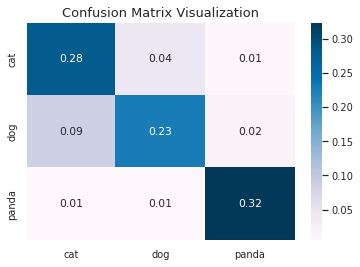

In [65]:
# Confusion Matrix Visualization
plt.title('Confusion Matrix Visualization',size=13)
sns.heatmap(confusion_matrix(y_true,y_pred_classes,normalize='all'), cmap='PuBu', annot=True, fmt='.2f')
plt.xticks([0.5,1.5,2.5],class_label.values())
plt.yticks([0.5,1.5,2.5],class_label.values())
plt.show()

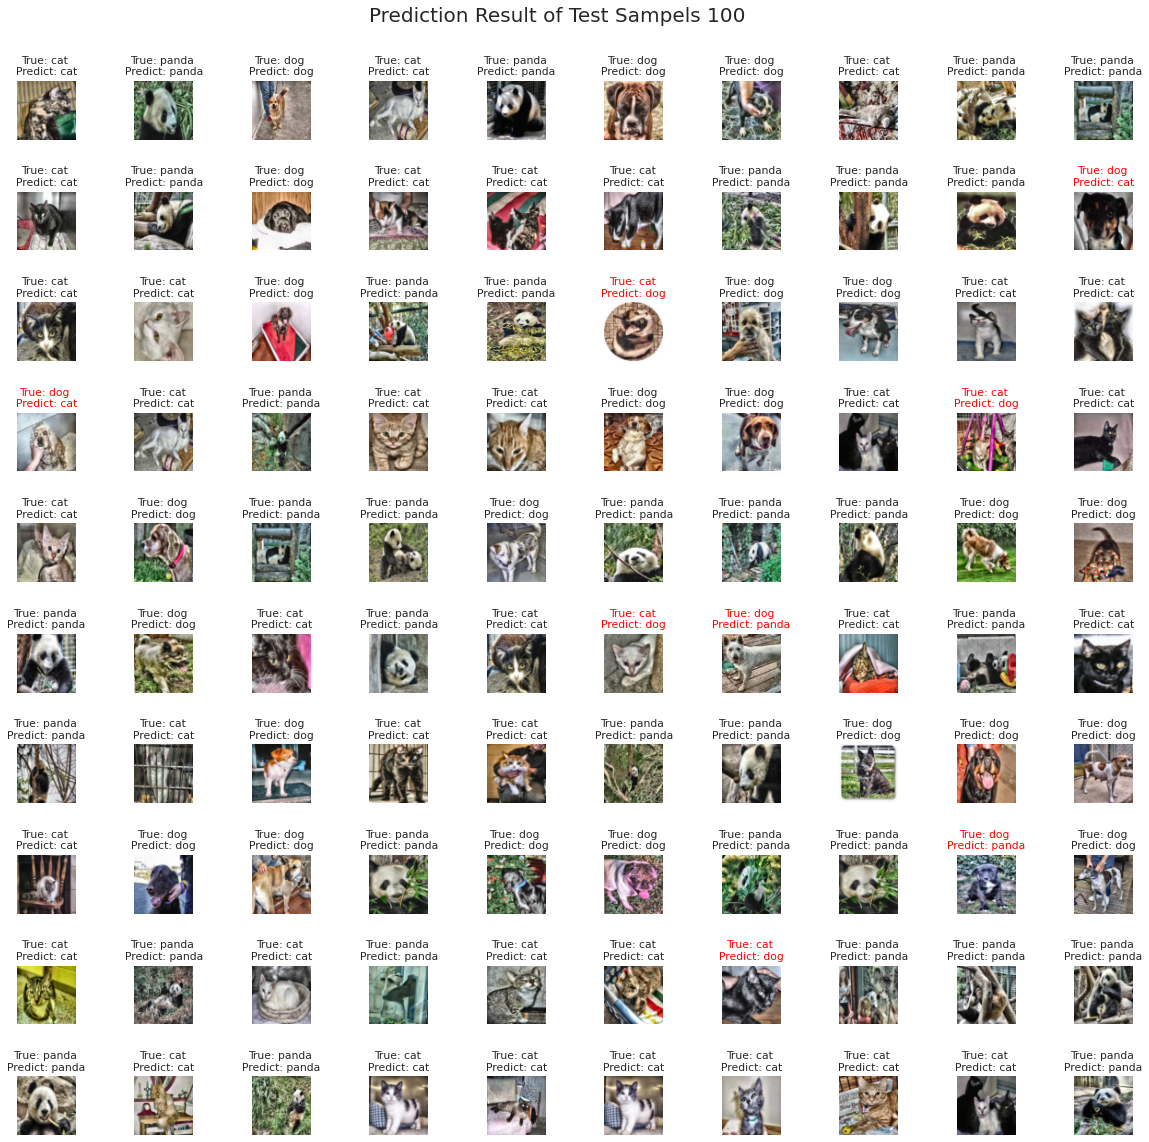

In [63]:
# Compare the Actual vs Predicted Results

sns.set(font_scale=0.9)
fig, axes = plt.subplots(10, 10, figsize=(20,20))
plt.suptitle('Prediction Result of Test Sampels 100', y=0.92, size=20)
axes = axes.ravel()

random_idx = np.random.randint(y_test.shape[0],size=100)

for i,idx in enumerate(random_idx):
  axes[i].imshow(X_test[idx])
  true_label, pred_label = class_label[y_true[idx]], class_label[y_pred_classes[idx]]
  if true_label != pred_label : axes[i].set_title('True: %s \nPredict: %s' % (true_label, pred_label), color='red')
  else: axes[i].set_title('True: %s \nPredict: %s' % (true_label, pred_label))
  axes[i].axis('off')
  plt.subplots_adjust(wspace=1)